In [1]:
%pip install numpy requests matplotlib

import json
import math
import random
import requests
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt


def load_ptb(drive_view_url):
    file_id = None
    parts = drive_view_url.split("/")
    if "drive.google.com" in drive_view_url and "file" in parts:
        try:
            file_id = parts[parts.index("d") + 1]
        except (ValueError, IndexError):
            raise ValueError("Could not extract file ID from URL.")
    else:
        raise ValueError("URL does not look like a Google Drive file/view link.")

    download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

    resp = requests.get(download_url)
    resp.raise_for_status()
    raw = resp.json()
    
    sentences = []
    for entry in raw:
        sentence_text, tag_list = entry
        words = sentence_text.split()
        if len(words) != len(tag_list):
            raise ValueError(
                f"Token/tag mismatch: {len(words)} words vs {len(tag_list)} tags\n"
                f"Sentence: {sentence_text}\nTags: {tag_list}"
            )
        sent = [(w, t) for w, t in zip(words, tag_list)]
        sentences.append(sent)
    return sentences


def train_test_split(sentences, train_ratio=0.8, seed=42):
    random.seed(seed)
    sentences_shuffled = sentences[:]
    random.shuffle(sentences_shuffled)
    cutoff = int(len(sentences_shuffled) * train_ratio)
    train_sents = sentences_shuffled[:cutoff]
    test_sents = sentences_shuffled[cutoff:]
    return train_sents, test_sents

Note: you may need to restart the kernel to use updated packages.


In [2]:
class HMMTrainer:
    def __init__(self):
        self.tag_counts = Counter()
        self.emit_counts = defaultdict(Counter)
        self.trans_counts_1 = defaultdict(Counter)
        self.trans_counts_2 = defaultdict(Counter)
        self.emit_prevword_counts = defaultdict(Counter)
        self.prevword_context_counts = Counter()
        self.init_counts = Counter()

    def train_counts(self, train_sents):
        for sent in train_sents:
            if not sent:
                continue

            first_word, first_tag = sent[0]
            self.init_counts[first_tag] += 1
            self.tag_counts[first_tag] += 1
            prev_word = "<START>"
            prev_tag = None

            tags_in_sent = [first_tag]
            self.emit_counts[first_tag][first_word] += 1
            self.emit_prevword_counts[(first_tag, prev_word)][first_word] += 1
            self.prevword_context_counts[(first_tag, prev_word)] += 1

            for i in range(1, len(sent)):
                word_i, tag_i = sent[i]
                word_prev, tag_prev = sent[i - 1]
                self.tag_counts[tag_i] += 1
                self.trans_counts_1[tag_prev][tag_i] += 1
                if i >= 2:
                    tag_prev2 = sent[i - 2][1]
                    self.trans_counts_2[(tag_prev2, tag_prev)][tag_i] += 1

                self.emit_counts[tag_i][word_i] += 1
                self.emit_prevword_counts[(tag_i, word_prev)][word_i] += 1
                self.prevword_context_counts[(tag_i, word_prev)] += 1

                tags_in_sent.append(tag_i)

        self.all_tags = list(self.tag_counts.keys())
        words_set = set()
        for _, wcount in self.emit_counts.items():
            words_set.update(wcount.keys())
        self.vocab = words_set
        self.most_freq_tag = self.tag_counts.most_common(1)[0][0]

    def get_initial_prob(self, tag, total_sentences):
        numerator = self.init_counts[tag] + 1
        denominator = total_sentences + len(self.all_tags)
        return math.log(numerator) - math.log(denominator)

    def get_trans_prob_1(self, prev_tag, curr_tag):
        numerator = self.trans_counts_1[prev_tag][curr_tag] + 1
        denominator = self.tag_counts[prev_tag] + len(self.all_tags)
        return math.log(numerator) - math.log(denominator)

    def get_trans_prob_2(self, prev2_tag, prev1_tag, curr_tag):
        bigram = (prev2_tag, prev1_tag)
        numerator = self.trans_counts_2[bigram][curr_tag] + 1
        denominator = sum(self.trans_counts_2[bigram].values()) + len(self.all_tags)
        return math.log(numerator) - math.log(denominator)

    def get_emit_prob(self, tag, word):
        numerator = self.emit_counts[tag][word]
        if numerator == 0:
            return float("-inf")
        denominator = self.tag_counts[tag]
        return math.log(numerator) - math.log(denominator)

    def get_emit_prob_prevword(self, tag, prev_word, word):
        numerator = self.emit_prevword_counts[(tag, prev_word)][word]
        denominator = self.prevword_context_counts[(tag, prev_word)]
        if numerator == 0 or denominator == 0:
            return float("-inf")
        return math.log(numerator) - math.log(denominator)

In [3]:
class HMMTagger:
    def __init__(self, trainer: HMMTrainer):
        self.trainer = trainer
        self.tags = trainer.all_tags
        self.N = len(self.tags)
        self.tag2idx = {tag: i for i, tag in enumerate(self.tags)}
        self.idx2tag = {i: tag for tag, i in self.tag2idx.items()}
        self.most_freq_tag = trainer.most_freq_tag
        self.vocab = trainer.vocab

    def viterbi_first_order(self, sentence_words):
        T = len(sentence_words)
        num_tags = self.N
        dp = [[float("-inf")] * num_tags for _ in range(T)]
        bp = [[-1] * num_tags for _ in range(T)]

        total_sents = sum(self.trainer.init_counts.values())
        w0 = sentence_words[0]
        for j, tag_j in enumerate(self.tags):
            log_p_init = self.trainer.get_initial_prob(tag_j, total_sents)
            if w0 in self.vocab:
                log_p_emit = self.trainer.get_emit_prob(tag_j, w0)
            else:
                if tag_j == self.most_freq_tag:
                    log_p_emit = math.log(1.0)
                else:
                    log_p_emit = float("-inf")
            dp[0][j] = log_p_init + log_p_emit
            bp[0][j] = -1

        for i in range(1, T):
            w_i = sentence_words[i]
            for j, tag_j in enumerate(self.tags):
                if w_i in self.vocab:
                    log_p_emit = self.trainer.get_emit_prob(tag_j, w_i)
                else:
                    if tag_j == self.most_freq_tag:
                        log_p_emit = math.log(1.0)
                    else:
                        log_p_emit = float("-inf")

                best_score = float("-inf")
                best_prev = -1
                for k, tag_k in enumerate(self.tags):
                    prev_score = dp[i - 1][k]
                    if prev_score == float("-inf"):
                        continue
                    log_p_trans = self.trainer.get_trans_prob_1(tag_k, tag_j)
                    score = prev_score + log_p_trans
                    if score > best_score:
                        best_score = score
                        best_prev = k
                dp[i][j] = best_score + log_p_emit
                bp[i][j] = best_prev

        best_final_score = float("-inf")
        best_final_tag = -1
        for j in range(num_tags):
            if dp[T - 1][j] > best_final_score:
                best_final_score = dp[T - 1][j]
                best_final_tag = j

        best_tags_idx = [0] * T
        best_tags_idx[T - 1] = best_final_tag
        for i in range(T - 1, 0, -1):
            best_tags_idx[i - 1] = bp[i][best_tags_idx[i]]

        best_tags = [self.idx2tag[idx] for idx in best_tags_idx]
        return best_tags

    def viterbi_second_order(self, sentence_words):
        T = len(sentence_words)
        num_tags = self.N
        START_IDX = num_tags
        dp = [
            [[float("-inf")] * (num_tags + 1) for _ in range(num_tags + 1)]
            for _ in range(T)
        ]
        bp = [[[-1] * (num_tags + 1) for _ in range(num_tags + 1)] for _ in range(T)]

        def idx2t(i):
            if i == START_IDX:
                return "<START>"
            return self.idx2tag[i]

        w0 = sentence_words[0]
        for j in range(num_tags):
            tag_j = self.idx2tag[j]
            total_sents = sum(self.trainer.init_counts.values())
            log_p_init = self.trainer.get_initial_prob(tag_j, total_sents)
            if w0 in self.vocab:
                log_p_emit = self.trainer.get_emit_prob(tag_j, w0)
            else:
                log_p_emit = 0.0 if tag_j == self.most_freq_tag else float("-inf")
            dp[0][START_IDX][j] = log_p_init + log_p_emit
            bp[0][START_IDX][j] = -1

        if T == 1:
            best_tag_idx = max(range(num_tags), key=lambda j: dp[0][START_IDX][j])
            return [self.idx2tag[best_tag_idx]]

        w1 = sentence_words[1]
        for j in range(num_tags):
            tag_j = self.idx2tag[j]
            for k in range(num_tags):
                tag_k = self.idx2tag[k]
                prev_score = dp[0][START_IDX][j]
                if prev_score == float("-inf"):
                    continue
                log_p_trans = self.trainer.get_trans_prob_1(tag_j, tag_k)
                if w1 in self.vocab:
                    log_p_emit = self.trainer.get_emit_prob(tag_k, w1)
                else:
                    log_p_emit = 0.0 if tag_k == self.most_freq_tag else float("-inf")
                dp[1][j][k] = prev_score + log_p_trans + log_p_emit
                bp[1][j][k] = START_IDX

        for i in range(2, T):
            w_i = sentence_words[i]
            for j in range(num_tags):
                tag_j = self.idx2tag[j]
                for k in range(num_tags):
                    tag_k = self.idx2tag[k]
                    best_score = float("-inf")
                    best_prev2 = -1
                    for x in range(num_tags):
                        tag_x = self.idx2tag[x]
                        prev_score = dp[i - 1][x][j]
                        if prev_score == float("-inf"):
                            continue
                        log_p_trans = self.trainer.get_trans_prob_2(tag_x, tag_j, tag_k)
                        score = prev_score + log_p_trans
                        if score > best_score:
                            best_score = score
                            best_prev2 = x
                    if w_i in self.vocab:
                        log_p_emit = self.trainer.get_emit_prob(tag_k, w_i)
                    else:
                        log_p_emit = (
                            0.0 if tag_k == self.most_freq_tag else float("-inf")
                        )
                    dp[i][j][k] = best_score + log_p_emit
                    bp[i][j][k] = best_prev2

        best_final_score = float("-inf")
        best_jk = (-1, -1)
        for j in range(num_tags):
            for k in range(num_tags):
                if dp[T - 1][j][k] > best_final_score:
                    best_final_score = dp[T - 1][j][k]
                    best_jk = (j, k)

        jT1, jT = best_jk
        best_tags_idx = [0] * T
        best_tags_idx[T - 2] = jT1
        best_tags_idx[T - 1] = jT

        for i in range(T - 1, 1, -1):
            prev2_idx = bp[i][best_tags_idx[i - 1]][best_tags_idx[i]]
            if prev2_idx == -1:
                prev2_idx = self.tag2idx[self.most_freq_tag]
            best_tags_idx[i - 2] = prev2_idx

        best_tags = [self.idx2tag[idx] for idx in best_tags_idx]
        return best_tags

    def viterbi_prevword(self, sentence_words):
        T = len(sentence_words)
        num_tags = self.N
        dp = [[float("-inf")] * num_tags for _ in range(T)]
        bp = [[-1] * num_tags for _ in range(T)]

        w0 = sentence_words[0]
        total_sents = sum(self.trainer.init_counts.values())
        for j, tag_j in enumerate(self.tags):
            log_p_init = self.trainer.get_initial_prob(tag_j, total_sents)
            if (
                (tag_j, "<START>") in self.trainer.prevword_context_counts
                and w0 in self.trainer.emit_prevword_counts[(tag_j, "<START>")]
            ):
                log_p_emit = self.trainer.get_emit_prob_prevword(tag_j, "<START>", w0)
            else:
                log_p_emit = 0.0 if tag_j == self.most_freq_tag else float("-inf")
            dp[0][j] = log_p_init + log_p_emit
            bp[0][j] = -1

        for i in range(1, T):
            w_i = sentence_words[i]
            w_prev = sentence_words[i - 1]
            for j, tag_j in enumerate(self.tags):
                best_score = float("-inf")
                best_prev = -1
                for k, tag_k in enumerate(self.tags):
                    prev_score = dp[i - 1][k]
                    if prev_score == float("-inf"):
                        continue
                    log_p_trans = self.trainer.get_trans_prob_1(tag_k, tag_j)
                    score = prev_score + log_p_trans
                    if score > best_score:
                        best_score = score
                        best_prev = k
                if (
                    (tag_j, w_prev) in self.trainer.prevword_context_counts
                    and w_i in self.trainer.emit_prevword_counts[(tag_j, w_prev)]
                ):
                    log_p_emit = self.trainer.get_emit_prob_prevword(tag_j, w_prev, w_i)
                else:
                    log_p_emit = 0.0 if tag_j == self.most_freq_tag else float("-inf")

                dp[i][j] = best_score + log_p_emit
                bp[i][j] = best_prev

        best_final_score = float("-inf")
        best_j = -1
        for j in range(num_tags):
            if dp[T - 1][j] > best_final_score:
                best_final_score = dp[T - 1][j]
                best_j = j

        best_tags_idx = [0] * T
        best_tags_idx[T - 1] = best_j
        for i in range(T - 1, 0, -1):
            best_tags_idx[i - 1] = bp[i][best_tags_idx[i]]

        return [self.idx2tag[idx] for idx in best_tags_idx]

In [4]:
def evaluate_tagger(tagger, test_sents, config_name):
    total_tokens = 0
    total_correct = 0
    tag_correct = Counter()
    tag_total = Counter()
    samples = []
    confusion = defaultdict(lambda: Counter())
    sent_len_acc = defaultdict(lambda: [0, 0])

    for sent in test_sents:
        words = [w for (w, t) in sent]
        true_tags = [t for (w, t) in sent]
        if config_name == "1st":
            pred_tags = tagger.viterbi_first_order(words)
        elif config_name == "2nd":
            pred_tags = tagger.viterbi_second_order(words)
        elif config_name == "prev_wd":
            pred_tags = tagger.viterbi_prevword(words)
        else:
            raise ValueError("Unknown config_name")

        length = len(words)
        for gt, pt in zip(true_tags, pred_tags):
            tag_total[gt] += 1
            confusion[gt][pt] += 1
            if gt == pt:
                total_correct += 1
                tag_correct[gt] += 1
                sent_len_acc[length][0] += 1
            sent_len_acc[length][1] += 1
            total_tokens += 1

        if len(samples) < 10 and random.random() < 0.05:
            samples.append((words, true_tags, pred_tags))

    overall_acc = total_correct / total_tokens
    tag_wise_acc = {tag: tag_correct[tag] / tag_total[tag] for tag in tag_total}
    sent_len_accuracy = {
        length: sent_len_acc[length][0] / sent_len_acc[length][1]
        for length in sent_len_acc
    }

    return overall_acc, tag_wise_acc, samples, confusion, sent_len_accuracy

In [5]:
NOUN_TAGS = {
    "NN",
    "NNS",
    "NNP",
    "NNPS",
    "PRP",
    "PRP$",
    "WP",
    "WP$",
}
VERB_TAGS = {"VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "MD"}
ADJ_ADV_TAGS = {
    "JJ",
    "JJR",
    "JJS",
    "RB",
    "RBR",
    "RBS",
    "WRB",
}

def collapse_tag(tag):
    if tag in NOUN_TAGS:
        return "N"
    elif tag in VERB_TAGS:
        return "V"
    elif tag in ADJ_ADV_TAGS:
        return "A"
    else:
        return "O"


def collapse_corpus(sentences):
    new_sents = []
    for sent in sentences:
        new_sent = []
        for w, t in sent:
            new_sent.append((w, collapse_tag(t)))
        new_sents.append(new_sent)
    return new_sents

In [6]:
random.seed(42)

# 1. Load all sentences
all_sents = load_ptb(
    "https://drive.google.com/file/d/1R1BLcghCh4j9Kl8_CR7MxZ4Wj57RiTxn/view"
)
print(f"Total sentences in PTB: {len(all_sents)}")
print("First 3 (word, tag) pairs of sentence #1:", all_sents[0][:3])
print("Full tags for sentence #1:", [t for (_, t) in all_sents[0]])
print("Full words for sentence #1:", [w for (w, _) in all_sents[0]])

# 2. Split into train/test
train_sents, test_sents = train_test_split(all_sents, train_ratio=0.8)
print(
    f"Training: {len(train_sents)} sentences. Testing: {len(test_sents)} sentences."
)

# 3. Train HMM on full 36-tag set
trainer_36 = HMMTrainer()
trainer_36.train_counts(train_sents)
tagger_36 = HMMTagger(trainer_36)

# 4. Evaluate 36-tag models
print("\n=== 36-Tag Model: First-Order HMM ===")
acc36_1, tag36_acc1, samples36_1, conf36_1, sentlen36_1 = evaluate_tagger(tagger_36, test_sents, "1st")
print(f"Overall Accuracy (36-tags, 1st-order): {acc36_1:.4f}")

print("\n=== 36-Tag Model: Second-Order HMM ===")
acc36_2, tag36_acc2, samples36_2, conf36_2, sentlen36_2 = evaluate_tagger(
    tagger_36, test_sents, "2nd"
)
print(f"Overall Accuracy (36-tags, 2nd-order): {acc36_2:.4f}")

print("\n=== 36-Tag Model: 1st-Order with Prev-Word Emission ===")
acc36_3, tag36_acc3, samples36_3, conf36_3, sentlen36_3 = evaluate_tagger(
    tagger_36, test_sents, "prev_wd"
)
print(f"Overall Accuracy (36-tags, prev-word): {acc36_3:.4f}")

# 5. Print 10 sample sentences for each variant
print("\n\n--- Sample Sentences, 36-Tags, 1st-Order HMM ---")
for words, true_tags, pred_tags in samples36_1:
    for w, t_true, t_pred in zip(words, true_tags, pred_tags):
        print(f"{w:15}  {t_true:4}  {t_pred:4}")
    print("-" * 30)

print("\n\n--- Sample Sentences, 36-Tags, 2nd-Order HMM ---")
for words, true_tags, pred_tags in samples36_2:
    for w, t_true, t_pred in zip(words, true_tags, pred_tags):
        print(f"{w:15}  {t_true:4}  {t_pred:4}")
    print("-" * 30)

print("\n\n--- Sample Sentences, 36-Tags, Prev-Word Emission ---")
for words, true_tags, pred_tags in samples36_3:
    for w, t_true, t_pred in zip(words, true_tags, pred_tags):
        print(f"{w:15}  {t_true:4}  {t_pred:4}")
    print("-" * 30)

# 6. Collapse training & test to 4 tags
train_sents_4 = collapse_corpus(train_sents)
test_sents_4 = collapse_corpus(test_sents)

# 7. Train on 4-tag set
trainer_4 = HMMTrainer()
trainer_4.train_counts(train_sents_4)
tagger_4 = HMMTagger(trainer_4)

# 8. Evaluate 4-tag models
print("\n=== 4-Tag Model: First-Order HMM ===")
acc4_1, tag4_acc1, samples4_1, conf4_1, sentlen4_1 = evaluate_tagger(
    tagger_4, test_sents_4, "1st"
)
print(f"Overall Accuracy (4-tags, 1st-order): {acc4_1:.4f}")

print("\n=== 4-Tag Model: Second-Order HMM ===")
acc4_2, tag4_acc2, samples4_2, conf4_2, sentlen4_2 = evaluate_tagger(
    tagger_4, test_sents_4, "2nd"
)
print(f"Overall Accuracy (4-tags, 2nd-order): {acc4_2:.4f}")

print("\n=== 4-Tag Model: 1st-Order with Prev-Word Emission ===")
acc4_3, tag4_acc3, samples4_3, conf4_3, sentlen4_3 = evaluate_tagger(
    tagger_4, test_sents_4, "prev_wd"
)
print(f"Overall Accuracy (4-tags, prev-word): {acc4_3:.4f}")

# 9. Print sample sentences for 4-tag set (if desired)
print("\n--- Sample Sentences, 4-Tags, 1st-Order HMM ---")
for words, true_tags, pred_tags in samples4_1:
    for w, t_true, t_pred in zip(words, true_tags, pred_tags):
        print(f"{w:15}  {t_true:4}  {t_pred:4}")
    print("-" * 30)

Total sentences in PTB: 3914
First 3 (word, tag) pairs of sentence #1: [('Pierre', 'NNP'), ('Vinken,', 'NNP'), ('61', 'CD')]
Full tags for sentence #1: ['NNP', 'NNP', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD']
Full words for sentence #1: ['Pierre', 'Vinken,', '61', 'years', 'old,', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29.']
Training: 3131 sentences. Testing: 783 sentences.

=== 36-Tag Model: First-Order HMM ===
Overall Accuracy (36-tags, 1st-order): 0.8561

=== 36-Tag Model: Second-Order HMM ===
Overall Accuracy (36-tags, 2nd-order): 0.8566

=== 36-Tag Model: 1st-Order with Prev-Word Emission ===
Overall Accuracy (36-tags, prev-word): 0.2059


--- Sample Sentences, 36-Tags, 1st-Order HMM ---
To               TO    TO  
the              DT    DT  
extent           NN    NN  
they             PRP   PRP 
did,             VBD   VBD 
their            PRP$  PRP$
concern          NN    NN  
was              VBD   

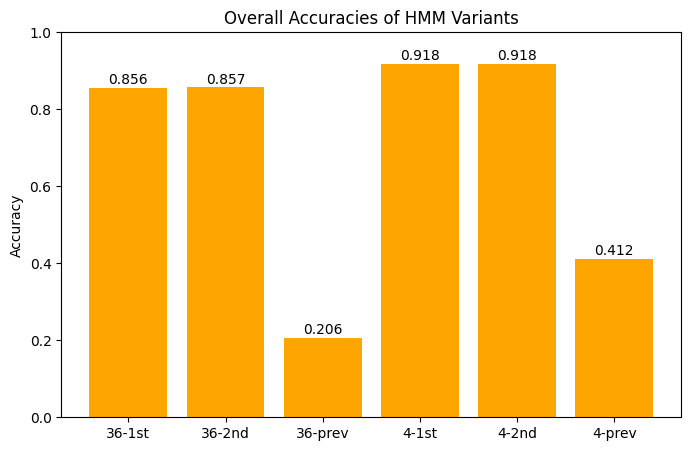

In [7]:
models = ["36-1st", "36-2nd", "36-prev", "4-1st", "4-2nd", "4-prev"]
accuracies = [acc36_1, acc36_2, acc36_3, acc4_1, acc4_2, acc4_3]
tag_freq36 = dict(trainer_36.tag_counts)

# 1. Overall Accuracy Comparison
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color="orange")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Overall Accuracies of HMM Variants")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()

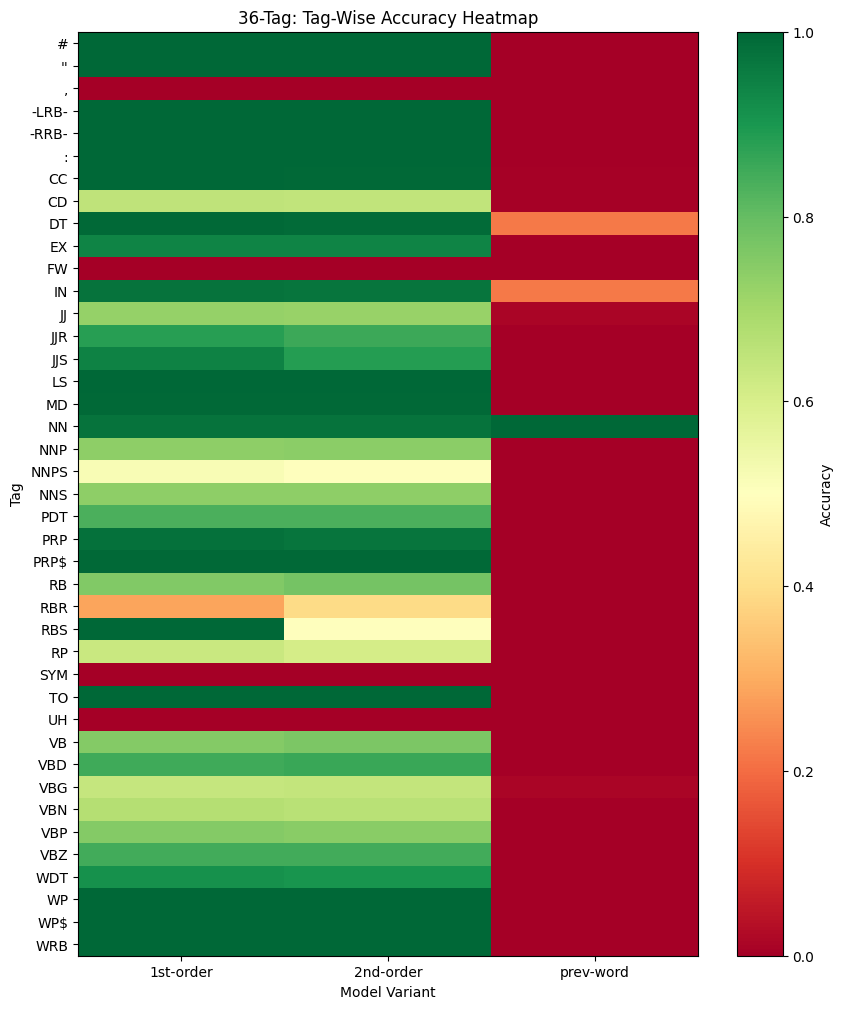

In [8]:
# 2. Tag-Wise Accuracy Heatmap (36-Tag, 3 variants)
tags36 = sorted(trainer_36.all_tags)
tag_to_idx36 = {tag: i for i, tag in enumerate(tags36)}
heatmap36 = np.zeros((len(tags36), 3))
for i, tag in enumerate(tags36):
    heatmap36[i, 0] = tag36_acc1.get(tag, 0)
    heatmap36[i, 1] = tag36_acc2.get(tag, 0)
    heatmap36[i, 2] = tag36_acc3.get(tag, 0)
plt.figure(figsize=(10, 12))
plt.imshow(heatmap36, aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)
plt.colorbar(label="Accuracy")
plt.yticks(range(len(tags36)), tags36)
plt.xticks([0, 1, 2], ["1st-order", "2nd-order", "prev-word"])
plt.title("36-Tag: Tag-Wise Accuracy Heatmap")
plt.xlabel("Model Variant")
plt.ylabel("Tag")
plt.show()

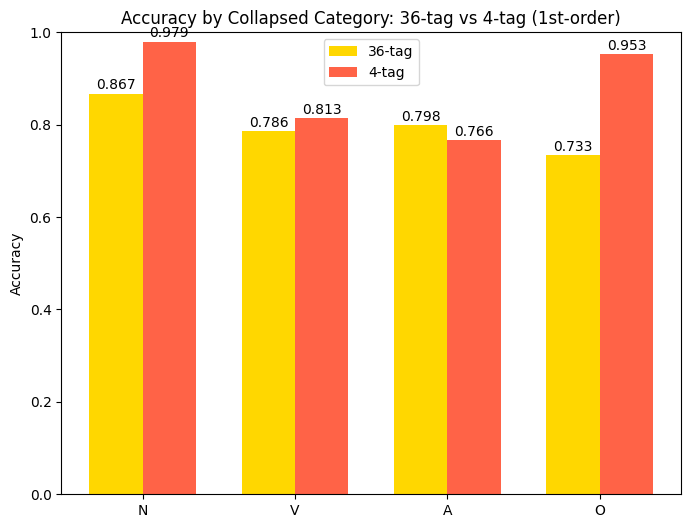

In [9]:
# 3. Tag-Wise Accuracy Bar Plot (4 tags vs 36 tags) for each collapsed category
collapsed_categories = ["N", "V", "A", "O"]
cat36_acc = {}
for cat in collapsed_categories:
    relevant_tags = [t for t in tags36 if collapse_tag(t) == cat]
    if relevant_tags:
        cat36_acc[cat] = np.mean([tag36_acc1.get(t, 0) for t in relevant_tags])
    else:
        cat36_acc[cat] = 0
cat4_acc = {cat: tag4_acc1.get(cat, 0) for cat in collapsed_categories}

x = np.arange(len(collapsed_categories))
width = 0.35
plt.figure(figsize=(8, 6))
plt.bar(
    x - width / 2,
    [cat36_acc[c] for c in collapsed_categories],
    width,
    label="36-tag",
    color="gold",
)
plt.bar(
    x + width / 2,
    [cat4_acc[c] for c in collapsed_categories],
    width,
    label="4-tag",
    color="tomato",
)
plt.xticks(x, collapsed_categories)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy by Collapsed Category: 36-tag vs 4-tag (1st-order)")
plt.legend()
for i, c in enumerate(collapsed_categories):
    plt.text(i - width / 2, cat36_acc[c] + 0.01, f"{cat36_acc[c]:.3f}", ha="center")
    plt.text(i + width / 2, cat4_acc[c] + 0.01, f"{cat4_acc[c]:.3f}", ha="center")
plt.show()

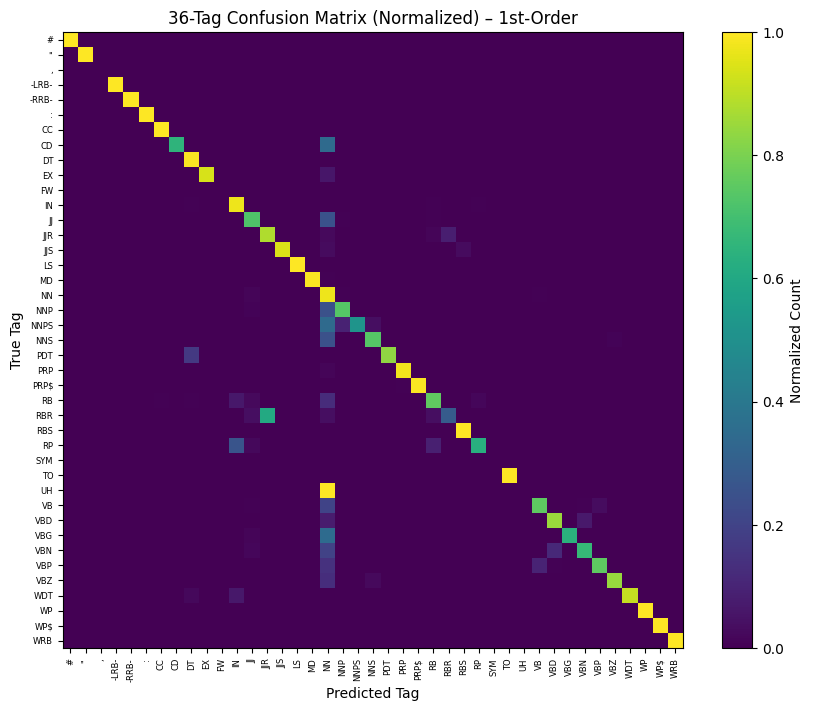

In [10]:
# 4. Confusion Matrix (36-tag, 1st-order)
conf_mat36 = np.zeros((len(tags36), len(tags36)))
for i, t_true in enumerate(tags36):
    total = sum(conf36_1[t_true].values())
    if total == 0:
        continue
    for j, t_pred in enumerate(tags36):
        conf_mat36[i, j] = conf36_1[t_true].get(t_pred, 0) / total

plt.figure(figsize=(10, 8))
plt.imshow(conf_mat36, aspect="auto", cmap="viridis")
plt.colorbar(label="Normalized Count")
plt.xticks(range(len(tags36)), tags36, rotation=90, fontsize=6)
plt.yticks(range(len(tags36)), tags36, fontsize=6)
plt.title("36-Tag Confusion Matrix (Normalized) – 1st-Order")
plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.show()

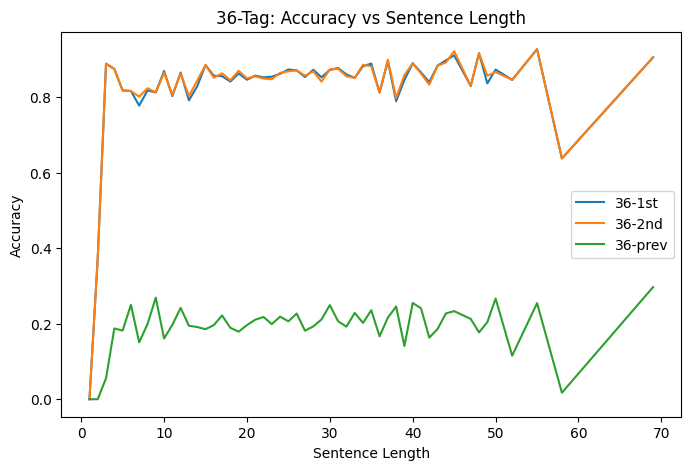

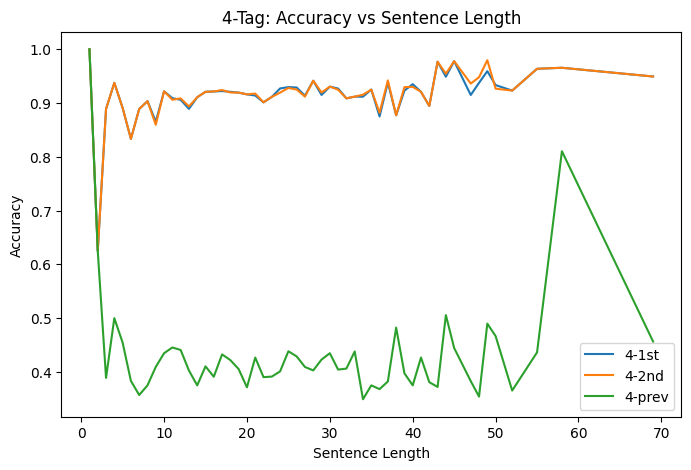

In [12]:
# 5. Accuracy vs. Sentence Length (Line Plot)
lengths = sorted(sentlen36_1.keys())
accs_len36_1 = [sentlen36_1[l] for l in lengths]
accs_len36_2 = [sentlen36_2.get(l, 0) for l in lengths]
accs_len36_3 = [sentlen36_3.get(l, 0) for l in lengths]
# Similarly for 4-tag
lengths4 = sorted(sentlen4_1.keys())
accs_len4_1 = [sentlen4_1[l] for l in lengths4]
accs_len4_2 = [sentlen4_2.get(l, 0) for l in lengths4]
accs_len4_3 = [sentlen4_3.get(l, 0) for l in lengths4]

plt.figure(figsize=(8, 5))
plt.plot(lengths, accs_len36_1, label="36-1st")
plt.plot(lengths, accs_len36_2, label="36-2nd")
plt.plot(lengths, accs_len36_3, label="36-prev")
plt.xlabel("Sentence Length")
plt.ylabel("Accuracy")
plt.title("36-Tag: Accuracy vs Sentence Length")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lengths4, accs_len4_1, label="4-1st")
plt.plot(lengths4, accs_len4_2, label="4-2nd")
plt.plot(lengths4, accs_len4_3, label="4-prev")
plt.xlabel("Sentence Length")
plt.ylabel("Accuracy")
plt.title("4-Tag: Accuracy vs Sentence Length")
plt.legend()
plt.show()

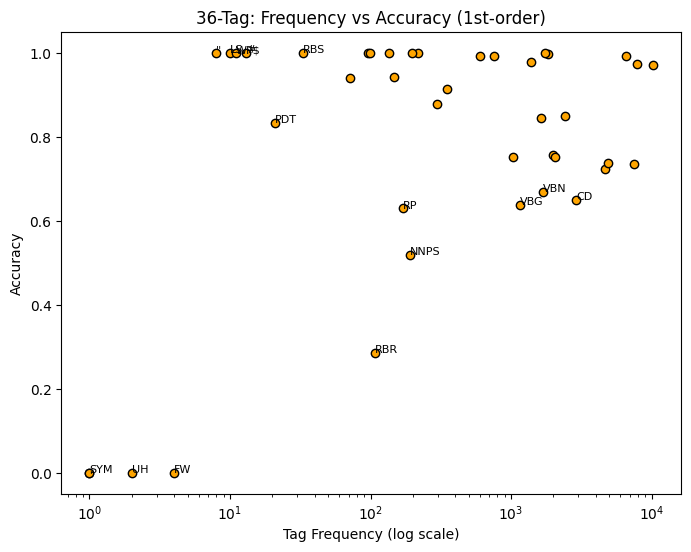

In [13]:
# 6. Tag Frequency vs Tag-Wise Accuracy (36-tag, 1st-order)

freqs = [tag_freq36[tag] for tag in tags36]
accs = [tag36_acc1.get(tag, 0) for tag in tags36]

plt.figure(figsize=(8, 6))
plt.scatter(freqs, accs, c="orange", edgecolors="black")
plt.xscale("log")
plt.xlabel("Tag Frequency (log scale)")
plt.ylabel("Accuracy")
plt.title("36-Tag: Frequency vs Accuracy (1st-order)")
for i, tag in enumerate(tags36):
    if freqs[i] < 50 or accs[i] < 0.7:
        plt.text(freqs[i], accs[i], tag, fontsize=8)
plt.show()

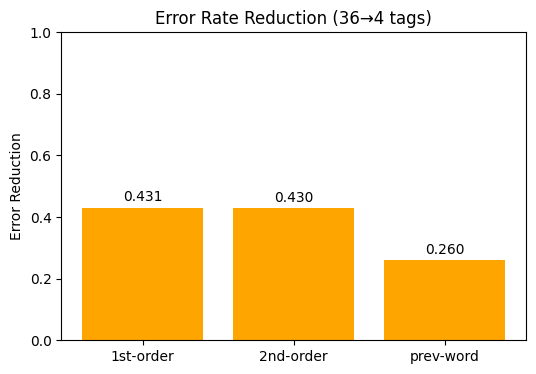

In [14]:
# 7. Error Rate Reduction (36 vs 4 tags)

err36 = 1 - acc36_1
err4 = 1 - acc4_1
errred = (err36 - err4) / err36 if err36 != 0 else 0
err36_2 = 1 - acc36_2
err4_2 = 1 - acc4_2
errred_2 = (err36_2 - err4_2) / err36_2 if err36_2 != 0 else 0
err36_3 = 1 - acc36_3
err4_3 = 1 - acc4_3
errred_3 = (err36_3 - err4_3) / err36_3 if err36_3 != 0 else 0

models_err = ["1st-order", "2nd-order", "prev-word"]
err_reductions = [errred, errred_2, errred_3]

plt.figure(figsize=(6, 4))
plt.bar(models_err, err_reductions, color="orange")
plt.ylim(0, 1)
plt.ylabel("Error Reduction")
plt.title("Error Rate Reduction (36→4 tags)")
for i, v in enumerate(err_reductions):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
plt.show()

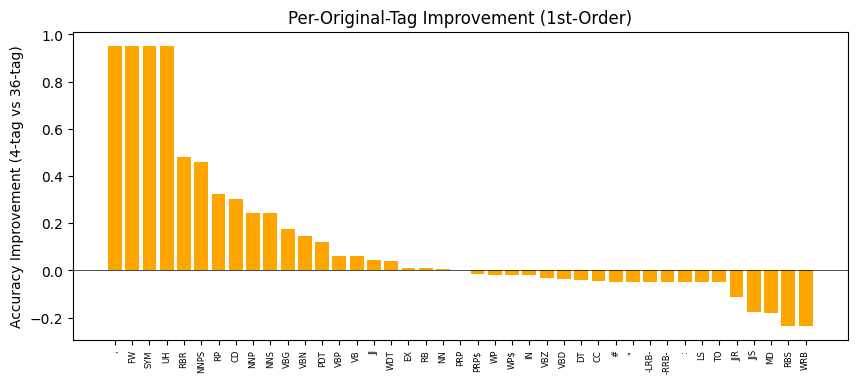

In [15]:
# 8. Per-Tag Accuracy Improvement (36→4 tags, first-order)

tag4_for_orig = {tag: tag4_acc1.get(collapse_tag(tag), 0) for tag in tags36}
delta = {tag: tag4_for_orig[tag] - tag36_acc1.get(tag, 0) for tag in tags36}
sorted_tags = sorted(tags36, key=lambda t: delta[t], reverse=True)
improvements = [delta[t] for t in sorted_tags]

plt.figure(figsize=(10, 4))
plt.bar(range(len(sorted_tags)), improvements, color="orange")
plt.xticks(range(len(sorted_tags)), sorted_tags, rotation=90, fontsize=6)
plt.ylabel("Accuracy Improvement (4-tag vs 36-tag)")
plt.title("Per-Original-Tag Improvement (1st-Order)")
plt.axhline(0, color="black", linewidth=0.5)
plt.show()